## Introducción

La idea del siguiente proyecto es construir un modelo de Machine Learning que prediga si una propiedad está subvaluada o sobrevaluada en función de diversas variables.

Nuestro primer paso será, mediante técnicas de WebScrapping, extraer información acerca de las propiedades que se encuentran en el portal Idealista, puntualmente en la región de Barcelona y durante el mes de Abril 2023.

Posteriormente prepararemos funciones para arreglar los datos de manera tal que puedan ser utilizados por nuestros modelos de ML.

Seguiremos con un Estudio Exploratorio (EDA) para entender mejor las distribuciones de los datos, sus correlaciones y atributos.

En el paso siguiente, divideremos los sets en Train, Test y Validation, para finalmente dar lugar a la aplicación de los modelos que encontremos convenientes. En esta etapa también evaluaremos métricas para identificar cuán fieles son estos y llegar al más eficaz

Finalizando este trabajo, haremos unas conclusiones y veremos si fue posible o no alcanzar el objetivo propuesto en este trabajo.

Agradecimientos a Javier Martín-Vazquez Carías y a su canal de YouTube Javi Data Science por subir esta propuesta y su ayuda al momento de revisar el proyecto final.

# A) Preparación del Web-Scrapping y nuestro DataFrame

Antes que nada, destacar que todo lo que se desarrolla en este apartado fue ejecutado en una instancia local de Visual Studio debido a que actualmente Colab no acepta algunas de las liberias que usaremos. Previamente también se instaló Anaconda con el fin de que podamos ejecutar Python.

En primer lugar lo que haremos será extraer los datos de una publicación a modo de ejemplo. Una vez lo tengamos  hecho, en el próximo apartado pasaremos a automatizarlo en sentido de que lo haga con todas las propiedades que queramos.

## Instalación/Importación de Librerías

In [ ]:
#Instalaremos las siguientes librarias
pip install undetected_chromedriver
pip install selenium

In [ ]:
#Importamos las siguientes librerias

import pandas as pd
import numpy as np

import requests
#Es para hacer peticiones a las páginas web
from bs4 import BeautifulSoup as bs
# Con ella extraeremos información desde el código HTML de la web que estemos visitando.

import random
# Nos permitirá conseguir números aleatorios que usaremos como intervalos al momento de ingresar a las webs y no ser detectados.

import time
# Esta función nos permite meter un delay al momento de extraer los datos (basado en el número aleatorio que utilizamos en el paso anterior)

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import undetected_chromedriver as uc

#Por medio de Selenium y undetected_chromedriver utilizaremos una instancia de Chrome para acceder al las webs de idealista y conseguir los datos.
#El uso de undetected_chromedriver es fundamental para que la web no reconozca que no hay un humano detrás, y nos permita acceder.

## Extracción de Información

In [ ]:
#El primer paso es abrir el navegador
browser = uc.Chrome()

In [ ]:
# Utilizaremos una publicación de idealista para examinar qué valores debemos conseguir.
url="https://www.idealista.com/inmueble/102256338/"

In [ ]:
# Entraremos en dicho enlace.
browser.get(url)

In [ ]:
# Si nos sale el aviso de cookies, podremos aceptarlo con el siguiente comando.
browser.find_element("xpath",'//*[@id="didomi-notice-agree-button"]').click()

In [ ]:
#Pasaremos a extraer el HTML de la web
html = browser.page_source
html

In [ ]:
#Esto nos dará un código realmente difícil de interpretar, que haremos más sencillo de leer con beautifulsoup
soup = bs(html, 'lxml')

In [ ]:
#Con este código ya podemos empezar a extraer los datos. La idea es que utilizando la Inspección de Código Fuente del Chrome (Botón derecho-Inspeccionar),
#podamos seleccionar el campo que nos interese, y ver cómo se le denomina. Una vez obtenida la denominación la incluiremos en las formulas
# de a continuación con tal de poder recoger la información que estemos buscando.

In [ ]:
titulo = soup.find('span',{'class':'main-info__title-main'}).text

localizacion = soup.find('span',{'class':'main-info__title-minor'}).text.split(',')[0]

precio = int(soup.find('span',{'class':'txt-bold'}).text.replace('.',''))

district_info = soup.find('li', {'class': 'header-map-list'}, text=lambda t: 'Distrito' in t)
if district_info is not None:
        district = district_info.text.strip().replace('Distrito', '').strip()
        print(district)
else:
        print('No se encontró la información del distrito')

ubicacion = soup.find('div',{'id':'headerMap'})
ubicacion

ubicacion_desg = [zona.text.strip() for zona in ubicacion.find_all('li')]
ubicacion_desg

In [ ]:
# Características
#Básicamente extraemos dentro de todos los 'class':'details-property', y 'details-property-feature-one' los apartados que empiezan en "li", que son
#los que estamos buscando.

c1 = soup.find('div',{'class':'details-property'}).find('div',{'class': 'details-property-feature-one'})
c1

caract_basicas = [caract.text.strip() for caract in c1.find_all('li')]
caract_basicas

c2 = soup.find('div',{'class':'details-property'}).find('div',{'class': 'details-property-feature-two'})
c2

caract_extra = [caract.text.strip() for caract in c2.find_all('li')]
caract_extra


## Automatización de la extracción

A modo de comprender la web de Idealista, al momento de buscar inmuebles en venta, uno escribe la localización que desea (en este caso Barcelona-Ciudad) y obtenemos un listado de varias páginas con cada uno de los resultados. Esta es la que llamaremos la URL-Madre. Nuestro objetivo será conseguir los ID's de todos los inmuebles que hay en cada una de esas páginas para posteriormente, entrar en cada uno de ellos y extraer sus características.

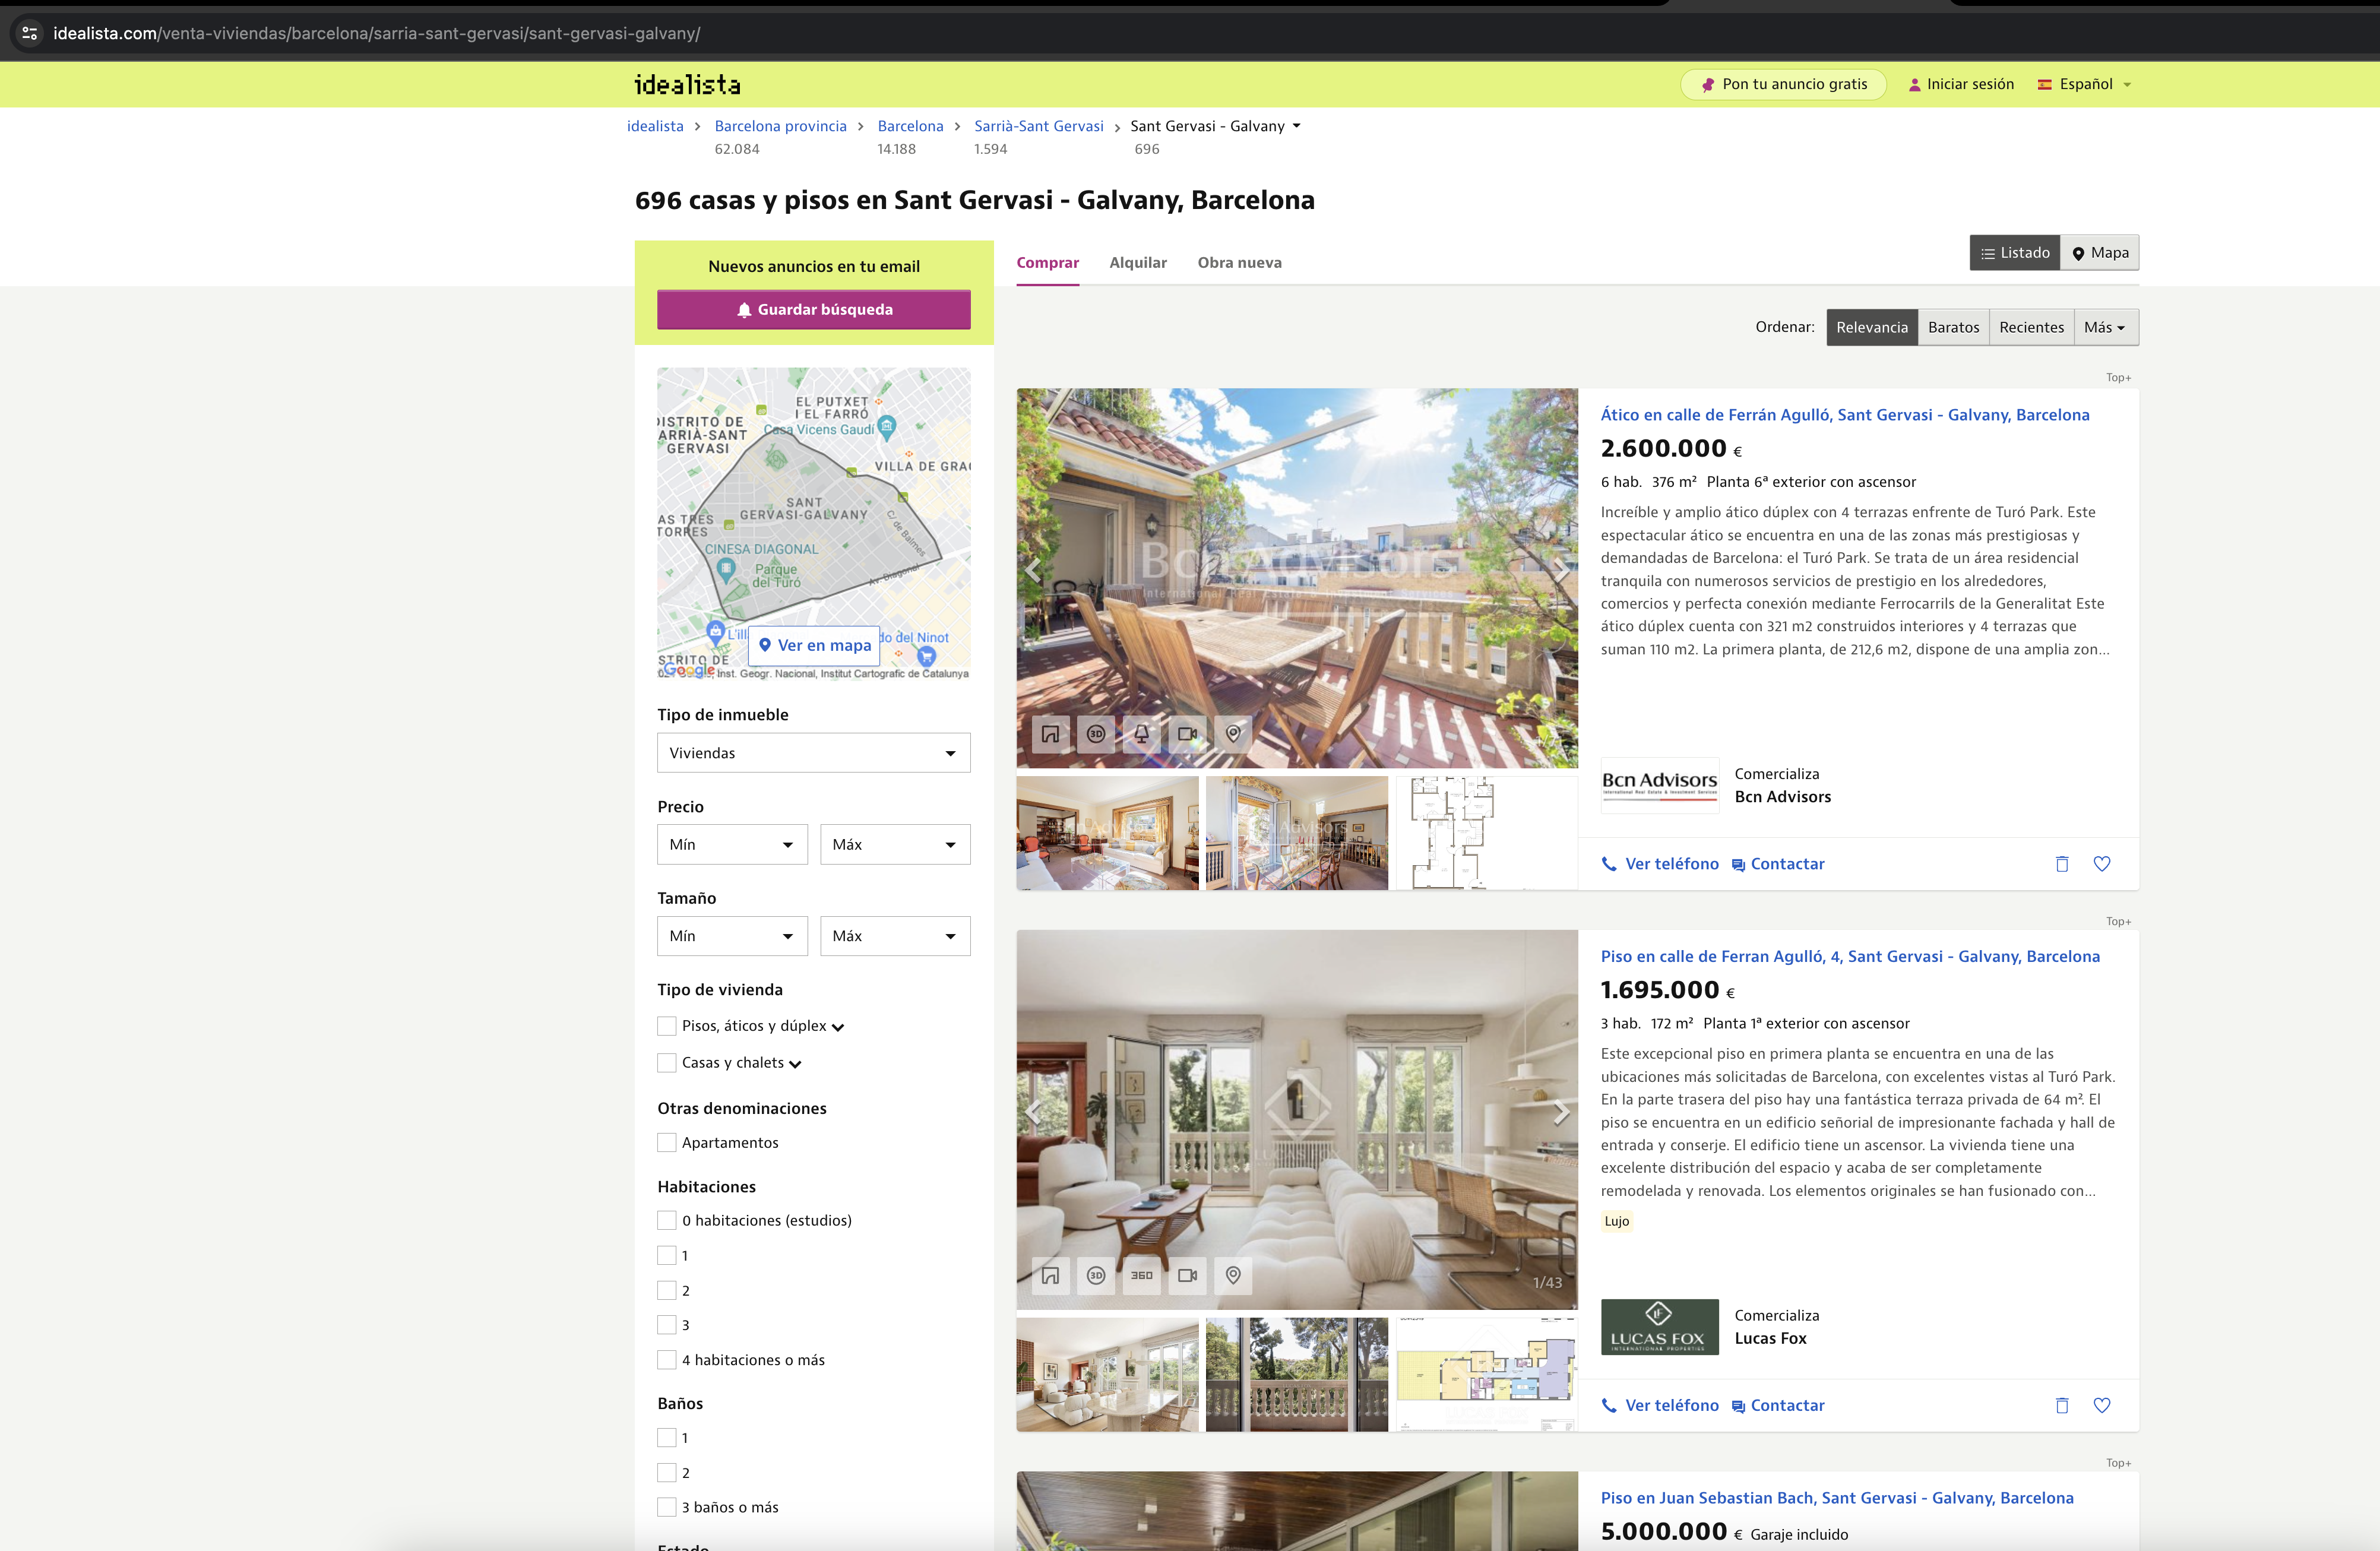

### a) Extracción de ID's de la URL_Madre

Nuestro primer paso en pos de automatizar la extracción, será extraer de la primer página de la URL-Madre todos los ID's de los inmuebles y guardarnoslo en un dataframe.

In [ ]:
#Primero ponemos la URL_Madre que será aquella en el que se encuentre el listado de inmuebles basado en donde hayamos buscado.
URL_Madre = https://www.idealista.com/venta-viviendas/barcelona-barcelona/

#Si no hemos cerrado el navegador, cargamos directamente la web
browser.get(URL_Madre)
#Resolvemos Cookies
browser.find_element("xpath",'//*[@id="didomi-notice-agree-button"]').click()
#Exportamos el HTML
html = browser.page_source
#Lo dejamos más fácil de leer
soup = bs(html, 'lxml')
soup
#Extraemos los articles, que son los apartados donde estarán los IDs
articles = soup.find('main',{'class':'listing-items'}).find_all('article')
articles
#Extraemos los ID's de las propiedades
id_muebles = [article.get('data-adid') for article in articles]
id_muebles
id_muebles = [muebles for muebles in id_muebles if muebles is not None]
id_muebles

El próximo paso es repetir todo lo anterior, pero para cada una de las páginas de la URL_Madre. Destacar que en el caso de Barcelona, contamos con muchos distritos, y muchos inmuebles en cada uno de ellos. A modo de evitar que haya TimeOuts, y podamos perder todos los ID's que hayamos obtenido, hemos decidido dividir el proceso en en 2 tandas.

In [ ]:
listado_barrios1=np.array(['eixample','ciutat-vella','gracia','horta-guinardo','les-corts'])
listado_barrios2=np.array(['nou-barris','sant-andreu','sant-marti','sants-montjuic','sarria-sant-gervasi'])


In [ ]:
#FUNCION ESPECIFICA PARA UN ARRAY DE VARIOS BARRIOS.
def buscar_ids_muebles(listado_barrios):

    # Inicializar la lista de ids
    ids = []

    # Realizar la búsqueda para cada barrio en el listado
    for barrio in listado_barrios:
        barrio_ids = []
        x = 1
        while True:

            url = f'https://www.idealista.com/venta-viviendas/barcelona/{barrio}/pagina-{x}.htm'

            browser.get(url)
            time.sleep(random.randint(10,12))

            try:
                browser.find_element("xpath", '//*[@id="didomi-notice-agree-button"]')
                browser.execute_script("arguments[0].click();", accept_cookies_button)
            except:
                pass

            html = browser.page_source
            soup = bs(html, 'lxml')

            pagina_actual = int(soup.find('main',{'class':'listing-items'}).find('div',{'class':'pagination'}).find('li',{'class':'selected'}).text)

            if x == pagina_actual:
                articles = soup.find('main',{'class':'listing-items'}).find_all('article')
            else:
                break

            x = x+1

            for article in articles:
                id_muebles = article.get('data-adid')
                barrio_ids.append(id_muebles)
                time.sleep(random.randint(1,3))

            barrio_ids = [muebles for muebles in barrio_ids if muebles is not None]

        ids += barrio_ids

    # Devolver la lista de ids encontrados
    return ids

In [ ]:
#Con dicha función armada, lanzamos el siguiente código para guardar todos los IDs del listado_barrios1 en un df.
ids_encontrados = buscar_ids_muebles(listado_barrios1)
ids_casas1 = pd.DataFrame(ids_encontrados)
ids_casas1.columns = ['id']
ids_casas1

In [ ]:
#Y repetimos los mismos pasos con el listado_barrios 2.
ids_encontrados = buscar_ids_muebles(listado_barrios2)
ids_casas2 = pd.DataFrame(ids_encontrados)
ids_casas2.columns = ['id']
ids_casas2

In [ ]:
#Finalmente unimos ambos df y exportamos este fichero para asegurarnos de no perder el listado.
ids_casas = pd.concat([ids_casas1, ids_casas2], ignore_index=True)
ids_casas=ids_casas.reset_index()
ids_casas=ids_casas.drop('index', axis=1)
ids_casas=ids_casas.drop_duplicates(keep='first')
ids_casas['id'] = ids_casas['id'].astype(str)


ids_casas.to_csv('ids_casas.csv',index = False)

### b) Extracción de Características de cada Inmueble

Una vez tenemos todos los ID's de los inmuebles de las que queremos extraer la información, nuestra intención será loopear el siguiente proceso:

*   Entrar en cada uno de los inmuebles a partir de su ID,
*   Extraer la información y guardarla en un DataFrame,
*   Esperar un intervalo de tiempo aleatorio,
*   Empezar otra vez.

In [ ]:
# Primero crearemos una serie donde iremos poniendo los atributos de cada piso
casas = pd.Series()

# Creamos una función que por cada ID que se le inserte, extraiga los atributos y lo ponga en un DataFrame
def parsear_inmueble(id_inmueble):

    print( '\n Casa numero: ' + id_inmueble)

    url = "https://www.idealista.com/inmueble/" + id_inmueble + "/"

    browser.get(url)

    html = browser.page_source

    soup = bs(html, 'lxml')

    titulo = soup.find('span',{'class':'main-info__title-main'}).text

    #print('\n Titulo: ' + titulo)

    localizacion = soup.find('span',{'class':'main-info__title-minor'}).text.split(',')[0]

    #print('\n Localizacion: ' + localizacion)
    precio = int(soup.find('span',{'class':'txt-bold'}).text.replace('.',''))

    c1 = soup.find('div',{'class':'details-property'}).find('div',{'class': 'details-property-feature-one'})

    caract_basicas = [caract.text.strip() for caract in c1.find_all('li')]

    #print('Caracteristicas basicas:' + caract_basicas)

    c2 = soup.find('div',{'class':'details-property'}).find('div',{'class': 'details-property-feature-two'})

    caract_extra = [caract.text.strip() for caract in c2.find_all('li')]

    #print('Caracteristicas extras:' + caract_extra)

    casas['titulo'] = titulo

    casas['localizacion'] = localizacion

    casas['precio'] = precio

    casas['caracteristicas_basicas'] = caract_basicas

    casas['caracteristicas_extras'] = caract_extra

    df_casas = pd.DataFrame(casas)

    return(df_casas.T)

In [ ]:
#Finalmente crearemos un loop para que se ocupe de todos los Id_casas que teníamos
df_casas = parsear_inmueble1(ids_casas.iloc[0].id)

for i in range(1, len(ids_casas)):
    df_casas = pd.concat([df_casas, parsear_inmueble1(ids_casas.iloc[i].id)])
    time.sleep(random.randint(4, 8))

In [ ]:
#Exportamos todo a CSV para evitar pérdidas:
df_casas.reset_index(drop=True, inplace=True)
df_casas.to_csv('casas_idealista.csv', index = False, sep = ';', encoding = 'utf-16')

NOTA: Si hay demasiados Inmuebles, pueden darse TimeOuts en la web. En ese caso, es recomendable dividir el listado de ID de Inmuebles en 2 o más partes, y finalmente unir todos los df resultantes en 1 sólo fichero.

# B) Data Engineering, EDA y Modelaje

Gracias al WebScrapping realizado en el paso previo, hemos llegado a preparar un fichero .csv que será con el cuál haremos el procesamiento de datos, el análisis descriptivo y finalmente la valoración de modelos de ML. Todo el siguiente apartado fue realizado en una instancia de Google Colab.

In [ ]:
#Lo comentamos porque ya está configurado en el notebook del colab
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
import re

In [ ]:
# Aplicamos el literal_eval para convertir el string de carácteristicas, en una lista
df = pd.read_csv('/content/drive/MyDrive/Portfolio/3.Idealista/df_casas_final_v2.csv',  encoding="utf-16",sep=';', converters={'caracteristicas_basicas':literal_eval,'caracteristicas_extras':literal_eval})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14159 entries, 0 to 14158
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id_inmueble              14159 non-null  int64 
 1   titulo                   14159 non-null  object
 2   distrito                 14159 non-null  object
 3   localizacion             14159 non-null  object
 4   precio                   14159 non-null  int64 
 5   caracteristicas_basicas  14159 non-null  object
 6   caracteristicas_extras   14159 non-null  object
dtypes: int64(2), object(5)
memory usage: 774.4+ KB


In [ ]:
df.head()

id_inmueble                                             titulo  distrito  \
0     98261311                   Piso en venta en paseo de Gràcia  Eixample   
1    100931690                 Piso en venta en calle de Provença  Eixample   
2    100025613                Piso en venta en ronda de Sant Pere  Eixample   
3    100228158  Ático en venta en Gran Via de les Corts Catalanes  Eixample   
4     98142672  Ático en venta en Gran Via de les Corts Catalanes  Eixample   

                      localizacion   precio  \
0           La Dreta de l'Eixample  1925000   
1           La Dreta de l'Eixample  1550000   
2           La Dreta de l'Eixample   730000   
3  L'Antiga Esquerra de l'Eixample   839000   
4           La Dreta de l'Eixample  1500000   

                             caracteristicas_basicas  \
0  [168 m² construidos, 2 habitaciones, 2 baños, ...   
1  [198 m² construidos, 178 m² útiles, 3 habitaci...   
2  [103 m² construidos, 84 m² útiles, 2 habitacio...   
3  [182 m² construidos, 3 habitaciones, 3 baños, ...   
4  [218 m² construidos, 4 habitaciones, 4 baños, ...   

                              caracteristicas_extras  
0  [Aire acondicionado, Piscina, Consumo: \n15 kW...  
1                                       [En trámite]  
2         [Aire acondicionado, Consumo:, Emisiones:]  
3  [Aire acondicionado, Consumo: \n198 kWh/m² año...  
4  [Aire acondicionado, Consumo: \n145 kWh/m² año...

## Preparacion de funciones


Comenzando en esta etapa de modificaciones de nuestro DataFrame, crearemos unas funciones  que nos permitirán extraer la información que necesitamos para nuestro trabajo. Como se habrá visto en el df.head() de más arriba, dentro de la columna **caracteristicas_basicas** y **caracteristicas_extras** nos encontramos con un string largo muy difícil de trabajar. Para poder extraer información de allí, al momento de cargar el CSV se utilizó la libreria literal_eval para poder pasarlos a lista y así utilizar las siguientes funciones.


Estas funciones van a ser **CORE** para poder crear todas las features de nuestro modelo.



*   **Match_property**, nos dirá si dentro de la de caracteristicas, ha encontrado la que estamos buscando, dando un posterior True o false
*   **Check_property**, nos dirá si de esa categoría puntual, ha encontrado un **CON** o **SIN**, dando lugar a 1 si tiene, o 0 si no tiene.

*  **Get_number**, nos dará el valor total en cuanto a cantidad de baños, habitaciones, etc.

In [ ]:
def match_property(property, patterns):
    for pat in patterns:
        match_prop = re.search(pat, property)
        if match_prop:
            return True
    return False

In [ ]:
def check_property(property, patterns):
  for pat in patterns:
    check = re.search(pat, property)
    if check:
      return 1
  return 0

In [ ]:
def get_number(property):
    nums = re.findall(r'\d+', property)
    if nums:
        if len(nums) == 2:
            return int(nums[0] + nums[1])
        else:
            return int(nums[0])
    else:
        return None

Ahora sí, pasamos a revisar función por función de cada columna. La idea será crear funciones en las cuales, si encuentra la feature que estamos buscando, (primer check_property), verifique si hay con o sin (match_property), para así definir qué variables existen. Por ejemplo, si encuentra la palabra ***ascensor***, tendrá que revisar si existe (palabra "con") o no (no encuentra nada), y así rellenar en la columna "ascensor" que crearemos, con un 1 o un 0.

In [ ]:
def get_obra_nueva(features):
  for prop in features:
    if match_property(prop.lower().strip(), ['obra nueva']):
      return 1
  return 0

In [ ]:
def get_buen_estado(features):
  for prop in features:
    if match_property(prop.lower().strip(), ['buen estado']):
      return 1
  return 0

In [ ]:
def get_para_reformar(features):
  for prop in features:
    if match_property(prop.lower().strip(), ['para reformar']):
      return 1
  return 0

In [ ]:
#Lo siguiente es una prueba para ver qué pasa si repitieramos check_property2 veces
def get_ascensor2(features):
  for prop in features:
      if check_property(prop.lower().strip(), ['ascensor']):
        return(check_property(prop.lower().strip(), ['con']))
  return 0

In [ ]:
def get_ascensor(features):
  for prop in features:
      if match_property(prop.lower().strip(), ['ascensor']):
        return(check_property(prop.lower().strip(), ['con']))
  return 0

In [ ]:
#hemos dado por hecho que al menos tiene que tener 1 baño. Se revisaron los casos que no ponía baño (4) y se veía que era un error de tipeo

def get_baños(features):
    for prop in features:
        if match_property(prop.lower().strip(), ['baño']):
            num = get_number(prop.lower().strip())
            if isinstance(num, (int, float)):
                return int(num)
    return 1

In [ ]:
# aquí hemos dicho que si no tiene habitación, sea un 0. Es decir, un estudio.
def get_habitaciones(features):
    for prop in features:
        if 'estudio' in prop.lower():
            return 0
        if match_property(prop.lower().strip(), ['habitaci']):
            num = get_number(prop.lower().strip())
            if isinstance(num, (int, float)):
                return int(num)
    return 0

In [ ]:
def get_año(features):
    for prop in features:
      if match_property(prop.lower().strip(), ['construido en']):
        return(get_number(prop.lower().strip()))

In [ ]:
def get_metros_construidos(features):
    for prop in features:
        if match_property(prop.lower().strip(), ['m² construidos']):
            match = re.search(r'\d+', prop.lower().strip())
            if match:
                return int(match.group())
    return 0

In [ ]:
def get_trastero(features):
    for prop in features:
      if match_property(prop.lower().strip(),['trastero']):
        return 1
    return 0

In [ ]:
def get_terraza(features):
    for prop in features:
      if match_property(prop.lower().strip(),['terraza']):
        return 1
    return 0

In [ ]:
def get_balcon(features):
    for prop in features:
      if match_property(prop.lower().strip(),['balcón','balcon']):
        return 1
    return 0

In [ ]:
def get_garaje(features):
    for prop in features:
      if match_property(prop.lower().strip(),['garaje']):
        return 1
    return 0

In [ ]:
def get_armarios(features):
    for prop in features:
      if match_property(prop.lower().strip(),['armarios']):
        return 1
    return 0

In [ ]:
def get_movilidad_reducida(features):
    for prop in features:
      if match_property(prop.lower().strip(),['movilidad reducida']):
        return 1
    return 0

In [ ]:
def get_exterior(features):
  for prop in features:
    if match_property(prop.lower().strip(),['exterior']):
      return 1
  return 0

In [ ]:
def get_atico(feature):
    if match_property(feature.lower().strip(), ['atico', 'atico', 'ático', 'azotea', 'ático']):
        return 1
    return 0

In [ ]:
def get_calefaccion(features):
  for prop in features:
    if match_property(prop.lower().strip(),['calefaccion','calefacción','Calefacción']) and match_property(prop.lower().strip(),['no','sin']):
      return 0
    elif match_property(prop.lower().strip(),['calefaccion','calefacción','Calefacción']):
      return 1
  return 0

In [ ]:
def get_aire_acondicionado(features):
  for prop in features:
    if match_property(prop.lower().strip(),['aire acondicionado','AC']):
      return 1
  return 0

In [ ]:
def get_piscina(features):
  for prop in features:
    if match_property(prop.lower().strip(),['piscina']):
      return 1
  return 0

In [ ]:
def get_zona_verde_jardin(features):
  for prop in features:
    if match_property(prop.lower().strip(),['zonas verdes','jardín','jardin','Jardín','Jardin']):
      return 1
  return 0

In [ ]:
df['obra_nueva'] = df.caracteristicas_basicas.dropna().apply(get_obra_nueva)
df['buen_estado'] = df.caracteristicas_basicas.dropna().apply(get_buen_estado) # Entenderemos que si es 0 es que es para reformar
#df['para_reformar'] = df.caracteristicas_basicas.dropna().apply(get_para_reformar)
df['ascensor']=df.caracteristicas_basicas.dropna().apply(get_ascensor)
df['baños']=df.caracteristicas_basicas.dropna().apply(get_baños)
df['habitaciones']=df.caracteristicas_basicas.dropna().apply(get_habitaciones)
df['año'] = df.caracteristicas_basicas.dropna().apply(get_año)
df['metros_construidos']=df.caracteristicas_basicas.dropna().apply(get_metros_construidos)
df['trastero']= df.caracteristicas_basicas.dropna().apply(get_trastero)
df['terraza']=df.caracteristicas_basicas.dropna().apply(get_terraza)
df['balcon']= df.caracteristicas_basicas.dropna().apply(get_balcon)
df['garaje']=df.caracteristicas_basicas.dropna().apply(get_garaje)
df['armarios']=df.caracteristicas_basicas.dropna().apply(get_armarios)
df['movilidad_reducida'] = df.caracteristicas_basicas.dropna().apply(get_movilidad_reducida)
df['exterior']=df.caracteristicas_basicas.dropna().apply(get_exterior)
df['atico']=df.titulo.dropna().apply(get_atico)
df['calefaccion']=df.caracteristicas_basicas.dropna().apply(get_calefaccion)
df['aire_acondicionado']= df.caracteristicas_extras.dropna().apply(get_aire_acondicionado)
df['piscina']= df.caracteristicas_extras.dropna().apply(get_piscina)
df['zona_verde_jardin']= df.caracteristicas_extras.dropna().apply(get_zona_verde_jardin)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14159 entries, 0 to 14158
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_inmueble              14159 non-null  int64  
 1   titulo                   14159 non-null  object 
 2   distrito                 14159 non-null  object 
 3   localizacion             14159 non-null  object 
 4   precio                   14159 non-null  int64  
 5   caracteristicas_basicas  14159 non-null  object 
 6   caracteristicas_extras   14159 non-null  object 
 7   obra_nueva               14159 non-null  int64  
 8   buen_estado              14159 non-null  int64  
 9   ascensor                 14159 non-null  int64  
 10  baños                    14159 non-null  int64  
 11  habitaciones             14159 non-null  int64  
 12  año                      9991 non-null   float64
 13  metros_construidos       14159 non-null  int64  
 14  trastero              

In [ ]:
df.head()

id_inmueble                                             titulo  distrito  \
0     98261311                   Piso en venta en paseo de Gràcia  Eixample   
1    100931690                 Piso en venta en calle de Provença  Eixample   
2    100025613                Piso en venta en ronda de Sant Pere  Eixample   
3    100228158  Ático en venta en Gran Via de les Corts Catalanes  Eixample   
4     98142672  Ático en venta en Gran Via de les Corts Catalanes  Eixample   

                      localizacion   precio  \
0           La Dreta de l'Eixample  1925000   
1           La Dreta de l'Eixample  1550000   
2           La Dreta de l'Eixample   730000   
3  L'Antiga Esquerra de l'Eixample   839000   
4           La Dreta de l'Eixample  1500000   

                             caracteristicas_basicas  \
0  [168 m² construidos, 2 habitaciones, 2 baños, ...   
1  [198 m² construidos, 178 m² útiles, 3 habitaci...   
2  [103 m² construidos, 84 m² útiles, 2 habitacio...   
3  [182 m² construidos, 3 habitaciones, 3 baños, ...   
4  [218 m² construidos, 4 habitaciones, 4 baños, ...   

                              caracteristicas_extras  obra_nueva  buen_estado  \
0  [Aire acondicionado, Piscina, Consumo: \n15 kW...           0            1   
1                                       [En trámite]           0            1   
2         [Aire acondicionado, Consumo:, Emisiones:]           0            1   
3  [Aire acondicionado, Consumo: \n198 kWh/m² año...           0            1   
4  [Aire acondicionado, Consumo: \n145 kWh/m² año...           0            1   

   ascensor  ...  balcon  garaje  armarios  movilidad_reducida  exterior  \
0         1  ...       1       0         1                   0         1   
1         1  ...       1       0         0                   0         1   
2         1  ...       0       0         1                   0         1   
3         1  ...       0       0         1                   0         1   
4         1  ...       1       0         1                   1         1   

   atico  calefaccion  aire_acondicionado  piscina  zona_verde_jardin  
0      0            0                   1        1                  0  
1      0            1                   0        0                  0  
2      0            1                   1        0                  0  
3      1            1                   1        0                  0  
4      1            1                   1        0                  0  

[5 rows x 26 columns]

**Notas:**


* **Metros_utiles**.  Quitaremos la columna porque hay unos 6.000 nulls. Siendo metros construidos el principal indicador.

* **Año**. Con esta variable nos encontramos unos casi 4.000 nulls por lo que valoraremos quitar esta columna


A pesar que ya hemos revisado los nulls, restaría revisar cuántas filas de columnas tenemos completadas con valores que NO sean cero. Esto nos sirve para detectar potenciales errores. Por ejemplo, no tendría sentido 100% de piscina en todos los pisos.

In [ ]:
# Calcula el porcentaje de valores distintos de cero en cada columna
porcentaje_no_ceros = df.apply(lambda col: (col != 0).mean() * 100)

# Muestra el resultado
print(porcentaje_no_ceros)

id_inmueble                100.000000
titulo                     100.000000
distrito                   100.000000
localizacion               100.000000
precio                     100.000000
caracteristicas_basicas    100.000000
caracteristicas_extras     100.000000
obra_nueva                   4.053959
buen_estado                 81.962003
ascensor                    73.698708
baños                      100.000000
habitaciones                98.643972
año                        100.000000
metros_construidos         100.000000
trastero                    15.205876
terraza                     36.407938
balcon                      40.433646
garaje                      15.905078
armarios                    34.783530
movilidad_reducida          13.065894
exterior                    79.701956
atico                        7.225087
calefaccion                 49.622148
aire_acondicionado          48.704005
piscina                      7.783036
zona_verde_jardin            7.196836
dtype: float

Haremos el mismo trabajo con cada columna, investigando cual es la media, y cuál es el valor mínimo y máximo.

In [ ]:

# Calcula el resumen estadístico
summary_stats = df.describe()

# Selecciona las métricas deseadas
metrics = ['max', 'min', 'mean', '50%']  # '50%' es la mediana

# Obtiene el resumen estadístico solo para las métricas seleccionadas
summary_metrics = summary_stats.loc[metrics]

# Transpone el resultado para que las métricas estén en las filas y las columnas representen las estadísticas
summary_metrics = summary_metrics.T

# Renombra las columnas para mayor claridad
summary_metrics.columns = ['Valor Máximo', 'Valor Mínimo', 'Promedio', 'Mediana']

# Muestra el resultado
print(summary_metrics)

                    Valor Máximo  Valor Mínimo      Promedio      Mediana
id_inmueble          100982651.0      320294.0  9.863307e+07  100164546.0
precio                25000000.0       42000.0  5.726973e+05     370000.0
obra_nueva                   1.0           0.0  4.053959e-02          0.0
buen_estado                  1.0           0.0  8.196200e-01          1.0
ascensor                     1.0           0.0  7.369871e-01          1.0
baños                       20.0           1.0  1.769546e+00          2.0
habitaciones                55.0           0.0  3.010806e+00          3.0
año                       2024.0        1700.0  1.957154e+03       1965.0
metros_construidos         981.0           1.0  1.149167e+02         89.0
trastero                     1.0           0.0  1.520588e-01          0.0
terraza                      1.0           0.0  3.640794e-01          0.0
balcon                       1.0           0.0  4.043365e-01          0.0
garaje                       1.0      

Aspectos llamativos que hemos detectado, casos con:



*   20 baños
*   55 habitaciones
*   1 metro de tamaño



In [ ]:
df.sort_values(by='habitaciones', ascending=False)[['id_inmueble', 'habitaciones']].head(10)

id_inmueble  habitaciones
5640      98398845            55
7305     100765232            50
4193      98272942            17
4639      99936989            17
5968     100819389            16
10881     93748640            15
3656      97393456            15
3688      92111424            15
1296      94780085            14
2140     100250840            12

In [ ]:
df.sort_values(by='baños', ascending=False)[['id_inmueble', 'baños']].head(10)

id_inmueble  baños
12007    100863239     20
3897      97742109     12
5714      99340853     10
10136     93916685      9
6075     100641102      9
1422      99404278      9
5723     100318133      9
9753     100079178      8
5578      81247994      8
5761      95776672      8

In [ ]:
df.sort_values(by='metros_construidos', ascending=True)[['id_inmueble', 'metros_construidos']].head(10)


id_inmueble  metros_construidos
5714      99340853                   1
9990      99319477                   1
9667      96739805                   1
10754     96100317                   1
10142     95771759                   1
11941     99796158                   1
10136     93916685                   1
6102      99494218                   1
10877     81411842                   1
5479      97162822                   1

Antes de pasar a la cocina y las modificaciones, haremos un BACKUP de todo lo generado hasta ahora.


In [ ]:
df_backup = df.copy()

## Cocina y modificaciones del DF

Como tenemos una importante cantidad de inmuebles, decidiré quitar las propiedades con 1 m2; con 50 o más habitaciones y con 12 o más baños.

In [ ]:
df = df.drop(df[df['metros_construidos'] == 1].index)
df = df.drop(df[df['habitaciones'] >= 50].index)
df = df.drop(df[df['baños'] >= 12].index)

Como mencionamos antes, probablemente trabajaremos con 2 dataframes distintos. Uno que tenga en cuenta el año, y otro que no.

In [ ]:
df=df.drop(df[df['distrito'] == 'Centre'].index) #Hay 1 fila que tiene esa localidad que en realidad no existe. vamos a quitarla.
df = df.drop(['caracteristicas_basicas', 'caracteristicas_extras','año','titulo'], axis=1).copy()
df.reset_index(drop=True, inplace=True)
print('df', len(df))

df 14142


In [ ]:
df.tail()

id_inmueble             distrito                localizacion   precio  \
14137     98232077  Sarrià-Sant Gervasi  Sant Gervasi - La Bonanova   520000   
14138     92670547  Sarrià-Sant Gervasi         Sarrià-Sant Gervasi   950000   
14139    100008210  Sarrià-Sant Gervasi         Sarrià-Sant Gervasi   935000   
14140    100894274  Sarrià-Sant Gervasi  Sant Gervasi - La Bonanova   530000   
14141     99028545  Sarrià-Sant Gervasi         Sarrià-Sant Gervasi  1075000   

       obra_nueva  buen_estado  ascensor  baños  habitaciones  \
14137           0            0         1      3             4   
14138           0            1         1      2             3   
14139           0            1         1      3             5   
14140           0            0         1      2             4   
14141           0            1         1      3             4   

       metros_construidos  ...  balcon  garaje  armarios  movilidad_reducida  \
14137                 123  ...       1       0         1                   0   
14138                 120  ...       0       0         1                   0   
14139                 200  ...       1       0         1                   0   
14140                 100  ...       1       0         0                   0   
14141                 127  ...       0       1         0                   0   

       exterior  atico  calefaccion  aire_acondicionado  piscina  \
14137         1      0            0                   0        0   
14138         1      1            1                   1        0   
14139         1      0            1                   1        0   
14140         1      0            1                   0        0   
14141         0      0            0                   0        0   

       zona_verde_jardin  
14137                  0  
14138                  0  
14139                  0  
14140                  0  
14141                  0  

[5 rows x 22 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14142 entries, 0 to 14141
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id_inmueble         14142 non-null  int64 
 1   distrito            14142 non-null  object
 2   localizacion        14142 non-null  object
 3   precio              14142 non-null  int64 
 4   obra_nueva          14142 non-null  int64 
 5   buen_estado         14142 non-null  int64 
 6   ascensor            14142 non-null  int64 
 7   baños               14142 non-null  int64 
 8   habitaciones        14142 non-null  int64 
 9   metros_construidos  14142 non-null  int64 
 10  trastero            14142 non-null  int64 
 11  terraza             14142 non-null  int64 
 12  balcon              14142 non-null  int64 
 13  garaje              14142 non-null  int64 
 14  armarios            14142 non-null  int64 
 15  movilidad_reducida  14142 non-null  int64 
 16  exterior            14

A fin de facilitar el trabajo que haremos en el siguiente EDA, catalogaremos las variables en **continuas**, **discretas** y separaremos los **distritos**.

In [ ]:
features_discretas=['obra_nueva','buen_estado','ascensor','trastero','terraza','balcon', 'garaje','armarios','movilidad_reducida','exterior','atico','calefaccion','aire_acondicionado','piscina','zona_verde_jardin']
features_continuas=['baños','habitaciones','metros_construidos']
distritos=['Eixample','Sant Martí','Sarrià-Sant Gervasi','Ciutat Vella','Sants-Montjuïc','Horta Guinardó','Gràcia','Sant Andreu','Nou Barris','Les Corts']
label=['precio']

## EDA

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [ ]:
#Plotly
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
import graphing
import plotly.express as px
import plotly.graph_objects as go

--2024-02-18 17:12:50--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21511 (21K) [text/plain]
Saving to: ‘graphing.py’

graphing.py         100%[===================>]  21.01K  --.-KB/s    in 0.001s  

2024-02-18 17:12:50 (29.1 MB/s) - ‘graphing.py’ saved [21511/21511]



In [ ]:
#Esto para poder vet todas las filas. Pero mejor pongamos 100
#pd.set_option('display.max_rows', 30)

Una primer pregunta que nos hacemos es saber cuántas localizaciones hay por cada distrito. Como veremos, hay bastantes, y a fines de simplificar variables, sólamente utilizaremos los distritos.

In [ ]:
#Como vemos, tenemos muchas localizaciones.
df.groupby('distrito')['localizacion'].nunique().reset_index()

distrito  localizacion
0         Ciutat Vella             5
1             Eixample             7
2               Gràcia             6
3       Horta Guinardó            10
4            Les Corts             3
5           Nou Barris            11
6          Sant Andreu             7
7           Sant Martí            11
8       Sants-Montjuïc            10
9  Sarrià-Sant Gervasi             7

A continuación veremos cuántos registros tenemos por cada Distrito.

In [ ]:
#Vamos ahora a hacer conteos solo por distrito.
distritos_grouped=(df
.groupby(["distrito"], as_index=False)
.agg(conteo_props = ("id_inmueble","count")
     )).sort_values("conteo_props", ascending=False)

total_props = df.shape[0]
distritos_grouped['porcentaje_total'] = round(100 * distritos_grouped['conteo_props'] / total_props, 1)

distritos_grouped

distrito  conteo_props  porcentaje_total
1             Eixample          1858              13.1
0         Ciutat Vella          1851              13.1
9  Sarrià-Sant Gervasi          1807              12.8
7           Sant Martí          1799              12.7
8       Sants-Montjuïc          1690              12.0
3       Horta Guinardó          1366               9.7
2               Gràcia          1066               7.5
5           Nou Barris           997               7.0
6          Sant Andreu           942               6.7
4            Les Corts           766               5.4

Ahora examinamos cómo está distribuida la cantidad de propiedades según el precio. Basandonos en la regla del Rango Intercuartil (ICQ),  podemos observar que contamos con muchos Outlyers que pasaremos a cuantificar.

In [ ]:
#Veamos las distribuciones. Primero por precio en general, y luego precio por Distrito.
fig = px.histogram(df, x='precio', nbins=30, histfunc='count',
                   title='Dist. por Precio para df_con_año', marginal='box', width=600, height=300)
#fig=px.box(df, x=label, y=col, width=1000, height=400)
print('')
fig.show()


In [ ]:

# Calcula Q1 y Q3
Q1 = df['precio'].quantile(0.25)
Q3 = df['precio'].quantile(0.75)

# Calcula el IQR
IQR = Q3 - Q1

# Calcula los límites para identificar valores atípicos
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# Filtra los valores atípicos
outliers = df[(df['precio'] < lower_fence) | (df['precio'] > upper_fence)]

# Cuenta la cantidad de valores atípicos
cantidad_outliers = len(outliers)

# Muestra la cantidad de valores atípicos
print(f'Cantidad de valores atípicos: {cantidad_outliers}')

Cantidad de valores atípicos: 1271


A fin de que nos afecten menos los valores atípicos a nuestra distribución, cogeremos como 1.5m € el tope máximo de valor de las propiedades, quitando aquellas que lo superen. A continuación volveremos a ver cómo queda la distribución.

In [ ]:
df = df[df['precio'] <= 1500000]
len(df)

13307

In [ ]:
#Veamos las distribuciones. Primero por precio en general, y luego precio por Distrito.
fig = px.histogram(df, x='precio', nbins=10, histfunc='count',
                   title='Dist. por Precio para df LIMPIO', marginal='box', width=600, height=300)
#fig=px.box(df, x=label, y=col, width=1000, height=400)
print('')
fig.show()

De acuerdo al gráfico podemos interpretar que al menos 50% de las propiedades están a menos de 400 mil euros, pero como veremos en instantes, también depende mucho del Distrito, por ejemplo, lidera la mediana, donde el 50% de los registros es igual o superior a 790K€, mientras que en Nou Barris, es de 183k.

In [ ]:
for distrito in distritos:
    fig=px.histogram(df[df['distrito']==distrito], x='precio', nbins=15, title=('Dist. Precio de ' + distrito), marginal='box', width=600, height=300)
    #fig=px.box(df, x=label, y=col, width=1000, height=400)
    print('')
    fig.show()

Algo interesante para revisar es la correlación que exista entre metros cuadrados y precio. Como podremos ver los valores están muy concentradores en menos de 200 metros construidos, subiendo rápidamente el precio.

In [ ]:
fig = px.scatter(df, x='metros_construidos', y='precio', title='Scatter Plot de Precio vs. Metros Construidos',
                 labels={'metros_construidos': 'Metros Construidos', 'precio': 'Precio'})
fig.update_traces(marker=dict(color='orange', opacity=0.5))
fig.update_layout(width=800, height=500)
fig.show()

Por este mismo motivo, haremos el mismo ejercicio para todos los distritos a ver si va mejor.

In [ ]:
fig = px.scatter(df, x='metros_construidos', y='precio', color='distrito',
                 title='Scatter Plot de Precio vs. Metros Construidos por Distrito',
                 labels={'metros_construidos': 'Metros Construidos', 'precio': 'Precio'},
                 width=800, height=500)
fig.update_traces(marker=dict(opacity=0.7))
fig.show()

En este apartado analizamos como es la distribución según **variables continuas** como son cantidad de habitaciones, metros cuadrados, etc.

In [ ]:
for col in features_continuas:
    fig=px.histogram(df, x=col, nbins=10,title=('Dist. de ' + col), marginal='box', width=600, height=300)
    #fig=px.box(df, x=label, y=col, width=1000, height=400)
    print('')
    fig.show()

Ahora valoramos la distribución de propiedades según **variables discretas** como si tienen o no baño, son o no obra nueva, etc.

Las conclusiones que sacamos son que:


*   <5% son Obras Nuevas
*   Más de 73% tienen ascensor
*   Más del 33% tienen terraza
*   Más del 87% no tienen trastero
*   35% Armarios empotrados
*   Sólo 14% acceso para movilidad reducida
*   Casi 80% son externos
*   La Calefacción y el aire están en casi 50%


In [ ]:
for col in features_discretas:
    counts = df[col].value_counts(normalize=True)
    labels = [str(round(counts[c]*100, 2)) + '%' for c in counts.index]

    # Invierte los labels solo para Ascensor y Exteriores. Hemos hecho esto porque si no los porcentajes salian al revés entre columnas.
    if col in ['ascensor', 'exterior','buen_estado']:
        labels = labels[::-1]

    fig = px.histogram(df, x=df[col].astype(str), title=('Dist. de ' + col), width=600, height=300, labels={'count': 'Porcentaje'})
    fig.update_xaxes(categoryorder='array', categoryarray=['0', '1'])
    fig.update_traces(text=labels, textposition='auto')
    fig.show()

En cuanto a análisis de correlaciones hemos detectado las siguientes conclusiones, que destacar NO implican causalidad.

 relevante que hemos visto es que el precio pareciera tener algo de correlación con metros

*   Correlación fuerte 0.73 entre precio y metros construidos, lo que es muy coherente siendo este una de las típicas principales variables.
*   En segundo lugar podemos mencionar con 0.69 los baños. Esta curiosa correlación la podemos interpretar en el sentido que las propiedades con más lujo y comododidad pueden tener contar más de 1 baño para su uso.
*   En tercer lugar se encontraría las habitaciones, aunque ya aquí ya bajamos a un 0.38, junto a Garaje que se lleva un 0.37. Las demas variables parecerían ya no afectar demasiado.



<ipython-input-57-7b95a11f33ac>:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



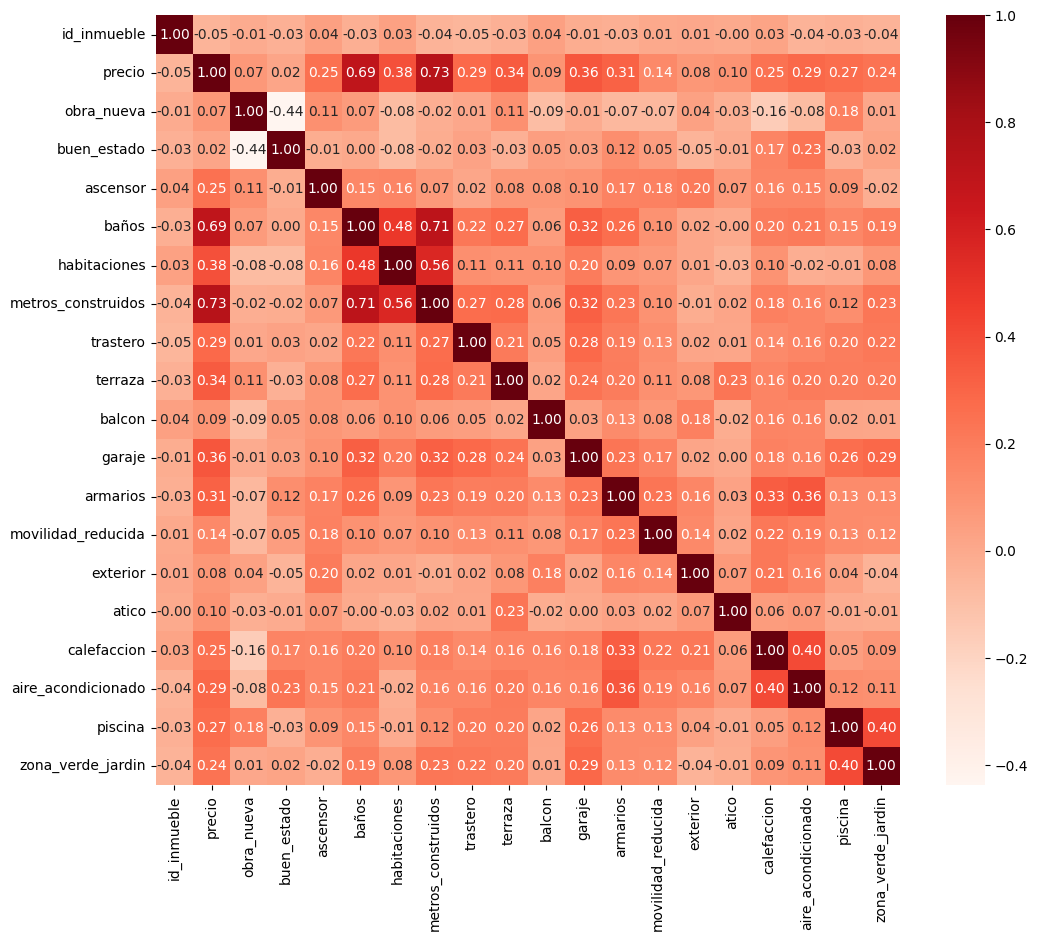

In [ ]:
#TEST DE CORRELACION ENTRE FEATURES. Tenemos muchas:

plt.figure(figsize=(12,10))
cor = df.corr()
#cor = df.loc[df_con_año['distrito'] == 'Gràcia'].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt=".2f")
plt.show()

## Modelaje

Ahora definiremos nuestras **x** e **y**, que serán necesarias para dar lugar a nuestro modelo. Destacar que además,utilizaremos el comando get_dummies para poder registrar los distritos en nuestro modelo de una manera válida.

In [ ]:
df_modelo_v1 = pd.get_dummies (df, columns = ["distrito"])

In [ ]:
x, y = df_modelo_v1.drop(["precio","id_inmueble","localizacion","metros_construidos","calefaccion","obra_nueva","habitaciones"], axis =1), df["precio"]

In [ ]:
#Librerias a utilizar

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import joblib

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
import scipy as sp
from sklearn.metrics import median_absolute_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

### Ridge Regression

In [ ]:
vars_casas = list(df_modelo_v1.columns)
vars_casas.remove ('precio')
vars_casas.remove ('id_inmueble')
vars_casas.remove ('localizacion')
vars_casas.remove ('metros_construidos')
vars_casas.remove ('calefaccion')
vars_casas.remove ('obra_nueva')
vars_casas.remove ('habitaciones')

model intercept: 12432.243339


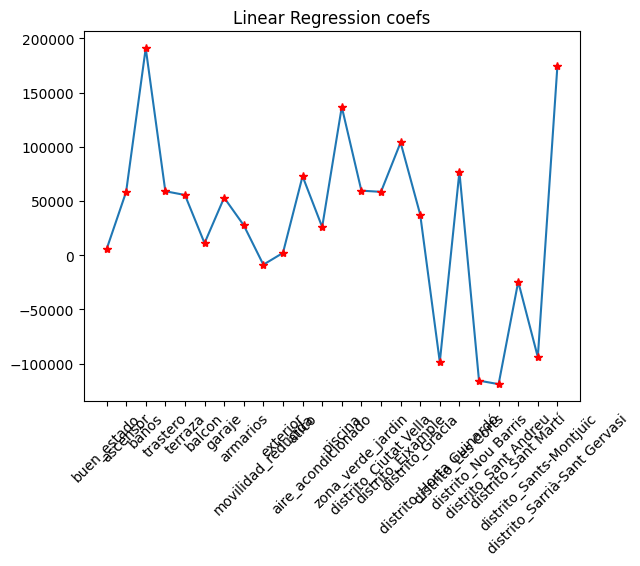

In [ ]:
lr_m = Ridge()
#ajuste sobre la muestra completa, sin split train-test
lr_m.fit(x, y)

print ("model intercept: %f" % lr_m.intercept_)

plt.xticks(range(len(vars_casas)), vars_casas, rotation=45)

plt.title( 'Linear Regression coefs')

_ = plt.plot(lr_m.coef_.T, '-', lr_m.coef_. T, 'r*')

MAE: 126972.249	R^2: 0.660


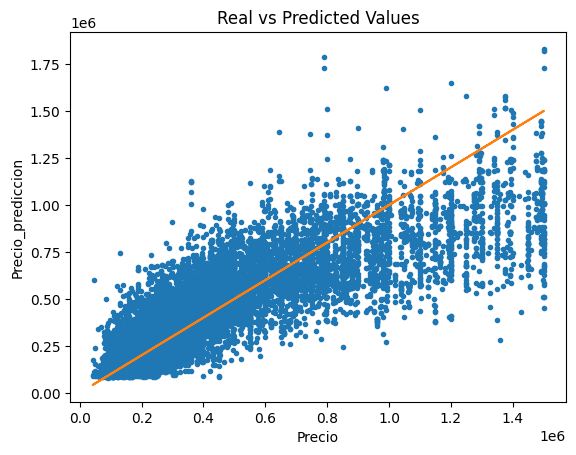

In [ ]:
y_pred = lr_m.predict (x)

print ("MAE: %.3f\tR^2: %.3f" % (mean_absolute_error (y, y_pred), lr_m.score(x, y)))
plt.title( 'Real vs Predicted Values')
plt.xlabel ('Precio')
plt.ylabel ('Precio_prediccion')
_ = plt.plot (y, y_pred, '.', y, y, '')

In [ ]:
from sklearn import model_selection

In [ ]:
n_folds = 10
kf = KFold(n_folds, shuffle=True)

scores = cross_val_score(lr_m, x, y, scoring="neg_mean_absolute_error", cv=kf,n_jobs=-1)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))


mae_mean: 127240.762		mae_std: 3928.556


Ahora pasamos a hacer la predicción con todos los valores que tenemos

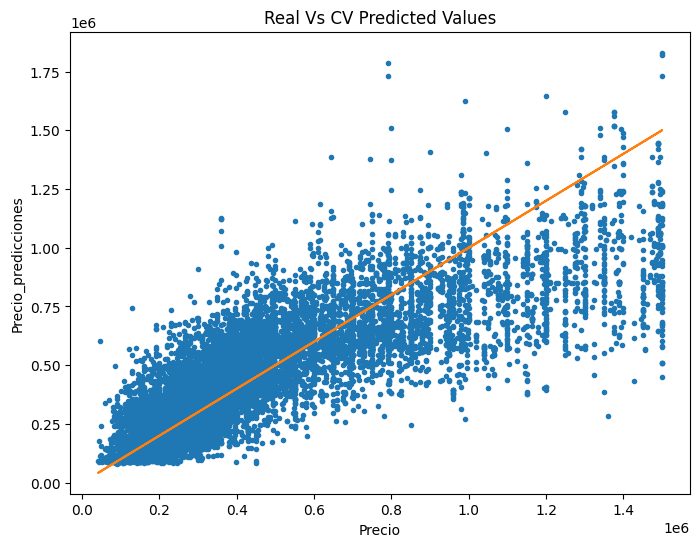

In [ ]:
plt.figure( figsize=(8,6))
plt.title( 'Real Vs CV Predicted Values')
plt.xlabel('Precio')
plt.ylabel ('Precio_predicciones')
_ = plt.plot (y, y_pred, '.', y, y, '-')

Ahora comparamos precio de cada propiedad real, y el que hemos estimado.

In [ ]:
# Crea un nuevo DataFrame con las columnas deseadas
df_resultados = df_modelo_v1.copy()

# Agrega la columna de predicciones al nuevo DataFrame
df_resultados['Precio_predicciones'] = y_pred

df_resultados['Precio_predicciones'] = df_resultados['Precio_predicciones'].apply(lambda x: f'{x:.2f}')

column_order = list(df_resultados.columns)  # Obtiene la lista de columnas originales
column_order.remove('precio')  # Remueve 'precio' para agregarlo después
column_order.append('precio')  # Agrega 'precio' al final
df_resultados = df_resultados[column_order]
# Muestra el nuevo DataFrame con las columnas originales y la de predicciones

df_resultados.sample(5)

id_inmueble                     localizacion  obra_nueva  buen_estado  \
6721     100785780    La Vila Olímpica del Poblenou           0            1   
13975     92724892                   Sants-Montjuïc           0            1   
13666    100952741                      El Poblenou           0            0   
4300      95599974                     La Teixonera           0            1   
1150     100898001  L'Antiga Esquerra de l'Eixample           0            1   

       ascensor  baños  habitaciones  metros_construidos  trastero  terraza  \
6721          1      2             4                 126         0        0   
13975         0      3             4                 146         0        0   
13666         1      1             3                  82         0        0   
4300          0      3             4                 248         0        1   
1150          1      2             5                 185         0        0   

       ...  distrito_Gràcia  distrito_Horta Guinardó  distrito_Les Corts  \
6721   ...                0                        0                   0   
13975  ...                0                        0                   0   
13666  ...                0                        0                   0   
4300   ...                0                        1                   0   
1150   ...                0                        0                   0   

       distrito_Nou Barris  distrito_Sant Andreu  distrito_Sant Martí  \
6721                     0                     0                    1   
13975                    0                     0                    0   
13666                    0                     0                    1   
4300                     0                     0                    0   
1150                     0                     0                    0   

       distrito_Sants-Montjuïc  distrito_Sarrià-Sant Gervasi  \
6721                         0                             0   
13975                        1                             0   
13666                        0                             0   
4300                         0                             0   
1150                         0                             0   

       Precio_predicciones  precio  
6721             516637.58  850000  
13975            496879.30  380000  
13666            304344.42  350000  
4300             626958.73  700000  
1150             590421.33  780000  

[5 rows x 32 columns]

Como podemos apreciar el MAE resulta bastante alto (127000), y de hecho, las predicciones también son muy dispares. A continuación veremos formas de mejorar este número. En primer lugar, vamos a recordar cómo es la distribución de precios.

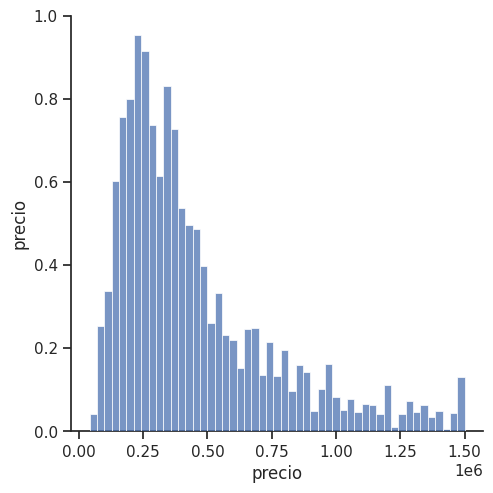

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df[['precio']], height=5)

Como podemos ver, hay valores muy alejados, de hecho, llenisimo de outlyers. La teoría nos recomienda normalizar los valores, lo cual lo podemos hacer aplicando logaritmos a la variable a predecir.

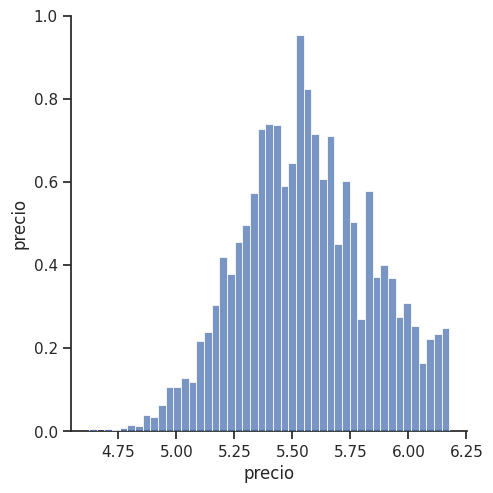

In [ ]:
sns.pairplot(np.log10(df[['precio']]), height=5)

Ahora haremos (de nuevo) la división entre train y test.

In [ ]:
df_modelo_v2 = df.copy()

In [ ]:
#Volvemos a definir x e y
x, y = df_modelo_v2.drop(["precio","id_inmueble","localizacion","calefaccion","obra_nueva","habitaciones"], axis =1), df_modelo_v2["precio"]


In [ ]:
#Destacar que ya hicimos en unos pasos previos que es x y qué es y. Lo que haremos ahora es crear nuestos TRAIN (70%); TEST (20%) y VALIDATION (10%). Esta última la haremos con el 90% de los datos.
from sklearn.model_selection import train_test_split
# División 70% para entrenamiento
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)

# División 20% para prueba y 10% para validación
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Combinar X_train y X_test para obtener el 90% total
X_train_2 = pd.concat([X_train, X_test])

# Combinar y_train y y_test para obtener el 90% total
y_train_2 = pd.concat([y_train, y_test])


In [ ]:
#Todo lo siguiente es por si tuvieramos que hacer OneHotEncoder, es decir,
#Estilo variables dummys para categoricas. Como ya lo tenemos resuelto, nos olvidamos

categorical_columns=["distrito"]
numerical_columns=[ "buen_estado", "ascensor",
 "baños", "metros_construidos", "trastero", "terraza", "balcon", "garaje", "armarios",
 "movilidad_reducida", "exterior", "atico", "calefaccion", "aire_acondicionado", "piscina",
 "zona_verde_jardin"]

preprocessor = make_column_transformer(
(OneHotEncoder(drop="if_binary"), categorical_columns),
remainder="passthrough",
verbose_feature_names_out=False,
)

In [ ]:
#Ahora aplicaremos el modelaje teniendo en cuenta que "y" vaya con log
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
    ),
    )

In [ ]:
#Con el modelo listo, hacemos fit con los datos de train, es decir, lo entrenamos
model.fit(X_train, y_train)

#Ahora vemos qué tan bien lo hacemos, midiendo accurates, comparando datos de entrenamiento con los de test.
#Lo que haremos será crear datos de predicciones (y) basados en los datos de entrenamiento

y_pred = model.predict(X_train)
mae = median_absolute_error(y_train, y_pred)
string_score = f"MAE on training set: {mae:.2f} euros"

y_pred = model.predict(X_test)
mae = median_absolute_error(y_test, y_pred)
string_score += f"\nMAE on testing set: {mae:.2f} euros"

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.22373e-18): result may not be accurate.



In [ ]:
from sklearn.metrics import median_absolute_error, r2_score

# Para el conjunto de entrenamiento
y_pred_train = model.predict(X_train)
mae_train = median_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
string_score_train = f"MAE on training set: {mae_train:.2f} euros\nR2 on training set: {r2_train:.2f}"

# Para el conjunto de prueba
y_pred_test = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
string_score_test = f"MAE on testing set: {mae_test:.2f} euros\nR2 on testing set: {r2_test:.2f}"

# Imprimir o usar string_score_train y string_score_test según lo necesites


In [ ]:
string_score_test

'MAE on testing set: 61337.32 euros\nR2 on testing set: 0.61'

Text(0.5, 0, 'Truths')

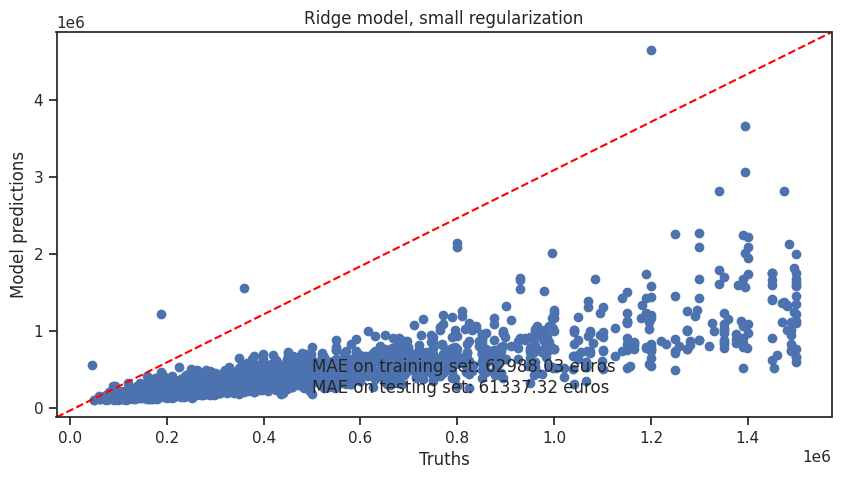

In [ ]:
fig, ax = plt.subplots (figsize= (10, 5))
plt.scatter (y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--" , c="red")
plt. text (500000, 200600, string_score)
plt.title ("Ridge model, small regularization")
plt.ylabel ("Model predictions")
plt.xlabel("Truths")

### Prueba de otros modelos

La intención a continuación es aplicar distintos modelos, también en los que se use logaritmos para normalizar la variable Y, y así encontrar el más eficaz.

### Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score

# Crear el modelo de regresión lineal
linear_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression(),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

# Entrenar el modelo en los datos de entrenamiento
linear_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = linear_model.predict(X_test)

# Calcular el rendimiento del modelo (MAE y R2)
mae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE en el conjunto de prueba: {mae:.2f} euros")
print(f"R2 en el conjunto de prueba: {r2:.2f}")


MAE en el conjunto de prueba: 61337.32 euros
R2 en el conjunto de prueba: 0.61


### Random Forest


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score

# Crear el modelo de Random Forest
random_forest_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=100, random_state=42),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

# Entrenar el modelo en los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = random_forest_model.predict(X_test)

# Calcular el rendimiento del modelo (por ejemplo, MAE)
mae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE en el conjunto de prueba: {mae:.2f} euros")
print(f"R2 en el conjunto de prueba: {r2:.2f}")


MAE en el conjunto de prueba: 40130.84 euros
R2 en el conjunto de prueba: 0.83


### Forest Normal

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score

# Crear el modelo de Decision Tree
decision_tree_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=DecisionTreeRegressor(random_state=42),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

# Entrenar el modelo en los datos de entrenamiento
decision_tree_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = decision_tree_model.predict(X_test)

# Calcular el rendimiento del modelo (MAE y R2)
mae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE en el conjunto de prueba: {mae:.2f} euros")
print(f"R2 en el conjunto de prueba: {r2:.2f}")


MAE en el conjunto de prueba: 41000.00 euros
R2 en el conjunto de prueba: 0.68


### XGBoost

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_val_score

# Crear el modelo XGBoost
xgboost_model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=XGBRegressor(random_state=42),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

# Entrenar el modelo en los datos de entrenamiento
xgboost_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = xgboost_model.predict(X_test)

# Calcular el rendimiento del modelo (MAE y R2)
mae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE en el conjunto de prueba: {mae:.2f} euros")
print(f"R2 en el conjunto de prueba: {r2:.2f}")

MAE en el conjunto de prueba: 46027.03 euros
R2 en el conjunto de prueba: 0.83


#C) Predicción FINAL usando Random Forest y Conclusiones

El modelo que escogeremos será el Random Forest, por lo que ahora utilizaremos el 90% de los datos y pasaremos a predecir el 10% en carácter de validación.

In [ ]:
#Entrenamiento final usando X_train 2 (90% de datos)


# Entrenar el modelo en los datos de entrenamiento
random_forest_model.fit(X_train_2, y_train_2)

# Realizar predicciones en el conjunto de prueba
y_pred_val = random_forest_model.predict(X_val)

# Calcular el rendimiento del modelo
mae = median_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print(f"MAE en el conjunto de prueba: {mae:.2f} euros")
print(f"R2 en el conjunto de prueba: {r2:.2f}")


MAE en el conjunto de prueba: 41494.44 euros
R2 en el conjunto de prueba: 0.82


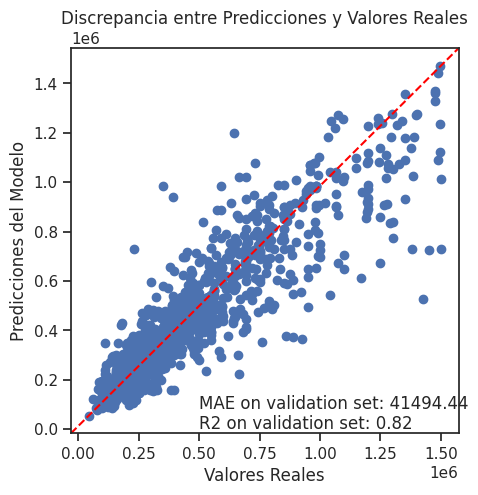

In [ ]:
string_score = f"MAE on validation set: {mae:.2f}\nR2 on validation set: {r2:.2f}"

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_val, y_pred_val)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--" , c="red")
plt.text(500000, 200e00, string_score)

plt.title("Discrepancia entre Predicciones y Valores Reales")
plt.ylabel("Predicciones del Modelo")
plt.xlabel("Valores Reales")
plt.show()


In [ ]:
#Por medio del siguiente código haremos unas predicciones para
# Obtener las filas del DataFrame original correspondientes al conjunto de validación
df_val_original = df.loc[X_val.index]

# Agregar la columna de predicciones
df_val_original['y_pred_val'] = y_pred_val

# Mostrar las primeras filas del DataFrame resultante
df_val_original.head(10)

id_inmueble        distrito                     localizacion   precio  \
1615      85156127        Eixample           La Dreta de l'Eixample  1290000   
5132      96952815  Horta Guinardó                   Horta Guinardó   171000   
12197    100410916      Nou Barris                   La Prosperitat   210000   
13787    100981456  Sants-Montjuïc                      Hostafrancs   359000   
3036     100815811    Ciutat Vella                         El Gòtic   960000   
9476      98736783  Sants-Montjuïc                      Hostafrancs   220000   
8195      99577445  Sants-Montjuïc  El Poble Sec - Parc de Montjuïc   230000   
4530     100723307  Horta Guinardó                      El Guinardó   130000   
2438     100398610    Ciutat Vella                     Ciutat Vella  1065000   
8269      87324180  Sants-Montjuïc  El Poble Sec - Parc de Montjuïc   295000   

       obra_nueva  buen_estado  ascensor  baños  habitaciones  \
1615            0            1         1      2             5   
5132            0            1         0      1             3   
12197           0            1         1      1             3   
13787           0            1         1      2             2   
3036            0            1         1      3             3   
9476            0            1         0      1             3   
8195            0            1         0      1             2   
4530            0            1         0      1             2   
2438            0            1         1      2             3   
8269            0            1         1      1             3   

       metros_construidos  ...  garaje  armarios  movilidad_reducida  \
1615                  174  ...       0         0                   0   
5132                   76  ...       0         1                   0   
12197                  78  ...       0         0                   1   
13787                  57  ...       0         1                   1   
3036                  166  ...       0         0                   0   
9476                   70  ...       0         0                   0   
8195                   60  ...       0         0                   0   
4530                   52  ...       0         0                   0   
2438                  130  ...       0         1                   0   
8269                   80  ...       0         0                   0   

       exterior  atico  calefaccion  aire_acondicionado  piscina  \
1615          1      0            1                   1        0   
5132          1      0            1                   1        0   
12197         1      1            1                   1        0   
13787         1      0            0                   1        0   
3036          0      0            0                   0        0   
9476          1      0            0                   0        0   
8195          1      0            0                   0        0   
4530          0      0            0                   0        0   
2438          0      0            1                   1        0   
8269          1      0            1                   1        0   

       zona_verde_jardin     y_pred_val  
1615                   0  835650.900170  
5132                   0  192599.609750  
12197                  0  243033.319897  
13787                  0  355851.840241  
3036                   0  966718.030546  
9476                   0  207883.729559  
8195                   0  231954.136656  
4530                   0  147517.032916  
2438                   0  902923.099254  
8269                   0  272568.786238  

[10 rows x 23 columns]

In [ ]:
# Obtener las importancias de las características
feature_importances = random_forest_model.named_steps['transformedtargetregressor'].regressor_.feature_importances_

# Obtener los nombres de las características
feature_names = model.named_steps['columntransformer'].get_feature_names_out()

# Crear un DataFrame con las importancias de las características
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Ordenar el DataFrame por importancia en orden descendente
importances_df = importances_df.sort_values(by='Importance', ascending=False)


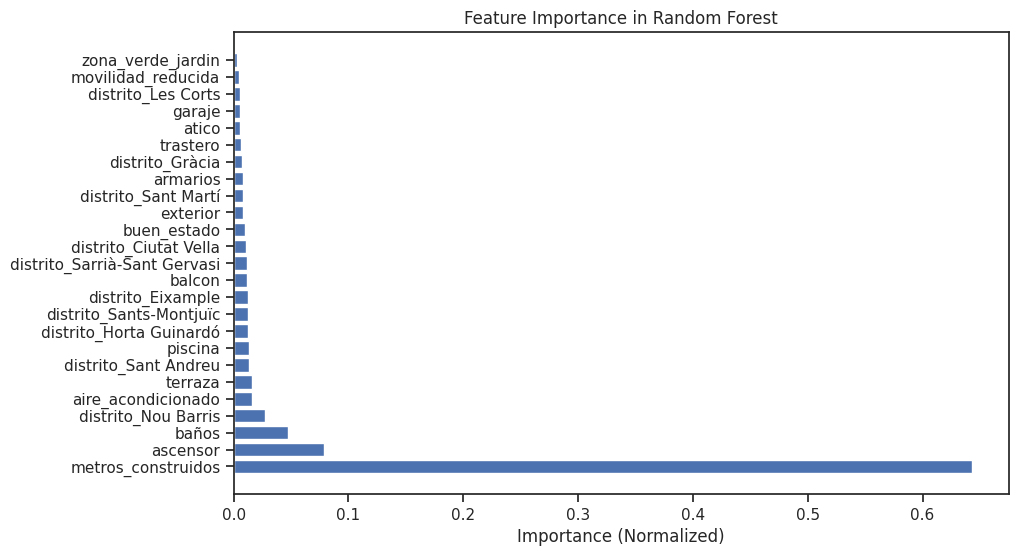

In [ ]:

# Crear un DataFrame con las importancias normalizadas de las características
importances_normalized = importances_df.copy()
importances_normalized['Importance'] /= importances_normalized['Importance'].sum()

# Ordenar el DataFrame por importancia en orden descendente
importances_normalized = importances_normalized.sort_values(by='Importance', ascending=False)

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importances_normalized['Feature'], importances_normalized['Importance'])
plt.xlabel('Importance (Normalized)')
plt.title('Feature Importance in Random Forest')
plt.show()


## Conclusiones

Por medio de este trabajo hemos logrado identificar un modelo que, con un aceptable grado de Accuracy, permite definir el precio de las propiedades de Barcelona de acuerdo a si tienen o no distintos atributos como metros, zona, etc. Como potenciales mejoras sería seguir mejorando los indicadores de Acuraccy,  como así también conectar este modelo directamente con la API de Idealista. Esto último fue lanzado en el año 2024 y permitiría acelerar el proceso de toma de datos, siendo la parte de WebScrapping una de las más arduas de este trabajo.